In [292]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def grid_show(to_shows, cols):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    plt.show()

def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
    
def visualize_heads(att_map, cols):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols)

def gray2rgb(image):
    return np.repeat(image[...,np.newaxis],3,2)
    
def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
        
    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])
    
    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]
    
    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    draw = ImageDraw.Draw(padded_image)
    draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)
    
    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask
    
    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1 
    
    return padded_image, padded_mask, meta_mask
    

def visualize_grid_to_grid_with_cls(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    attention_map = att_map[grid_index]
    cls_weight = attention_map[0]
    
    mask = attention_map[1:].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    padded_image ,padded_mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)
    
    if grid_index != 0: # adjust grid_index since we pad our image
        grid_index = grid_index + (grid_index-1) // grid_size[1]
        
    grid_image = highlight_grid(padded_image, [grid_index], (grid_size[0], grid_size[1]+1))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(padded_mask, alpha=alpha, cmap='rainbow')
    ax[1].imshow(meta_mask)
    ax[1].axis('off')
    

def visualize_grid_to_grid(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    H,W = att_map.shape
    with_cls_token = False
      
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = att_map[:, grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()
    
def highlight_grid(image, grid_indexes, grid_size=14):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    # for grid_index in grid_indexes:
    #     x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
    #     a= ImageDraw.ImageDraw(image)
    #     a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image


In [293]:
from collections import OrderedDict
import torch

from functools import partial
from torchvision import transforms as T
from timm.models import create_model, load_checkpoint, is_model, list_models
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, DEFAULT_CROP_PCT
from timm.data.auto_augment import rand_augment_transform, augment_and_mix_transform, auto_augment_transform
from timm.data.transforms import RandomResizedCropAndInterpolation, ToNumpy, ToTensor
from timm.data.transforms_factory import transforms_imagenet_eval, create_transform
from timm.data.random_erasing import RandomErasing



import cv2

from visualizer import get_local
get_local.activate()

from models import *

# pretrained = "outputs/scene_recognition/mixformer_small_224/exp3/model_best.pth.tar"
# img_path = "datasets/millionaid/all_img/"

pretrained = "outputs/classification/mixformer_small_224/exp5/model_best.pth.tar"
# img_path = "datasets/millionaid/all_img/"


if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda")


# create model
in_chans = 3

model = lemevit_small(num_classes=1000)

ckpt = torch.load(pretrained, map_location='cpu')
if 'state_dict' in ckpt:
    _state_dict = ckpt['state_dict']
elif 'state_dict_ema' in ckpt:
    _state_dict = ckpt['state_dict_ema']
elif 'model' in ckpt:
    _state_dict = ckpt['model']
else:
    _state_dict = ckpt

state_dict = OrderedDict()
for k, v in _state_dict.items():
    if k.startswith('backbone.'):
        state_dict[k[9:]] = v
    else:
        state_dict[k] = v

# # strip prefix of state_dict
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k[7:]: v for k, v in state_dict.items()}

# # delete attn_mask since we always re-init it
attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
for k in attn_mask_keys:
    del state_dict[k]

# load state_dict
print(model.load_state_dict(state_dict, True))

model = model.to(device)

model.eval()

transform = create_transform(224,is_training=False, no_aug=True, interpolation="bicubic",crop_pct=DEFAULT_CROP_PCT)





<All keys matched successfully>


In [294]:
# pretrained ="outputs/classification/mixformer_tiny_224/exp2/model_best.pth.tar"

# img = "datasets/IMNET1k/train/n02007558/n02007558_182.JPEG"
# img = "P0414322.jpg"
# img = "P0664867.jpg"
# img = "P0571292.jpg"
# img = "P0584807.jpg"
# img_path = img_path + img
# img_path = "datasets/IMNET1k/train/n02086646/n02086646_7046.JPEG"

# img_path = "datasets/IMNET1k/train/n01531178/n01531178_8345.JPEG"

img_path = "datasets/IMNET1k/train/n02093859/n02093859_3437.JPEG"

# img_path = "datasets/IMNET1k/train/n02093859/n02093859_3728.JPEG"

img_size = 224

img = Image.open(img_path).convert('RGB')
cv_img = cv2.imread(img_path)

input = transform(img)

cv2.imwrite("1.jpg",cv_img)
input = input.unsqueeze(0).to(device)
out = model(input)


cache = get_local.cache
ma_list = cache["MixAttention.forward"]
# sa_list = cache["StandardAttention.forward"]


Mix: tensor([[[[0.1874, 0.0178, 0.0173,  ..., 0.0225, 0.0180, 0.0169],
          [0.1961, 0.0200, 0.0195,  ..., 0.0214, 0.0198, 0.0191],
          [0.2009, 0.0200, 0.0195,  ..., 0.0207, 0.0197, 0.0191],
          ...,
          [0.1084, 0.0446, 0.0447,  ..., 0.0431, 0.0430, 0.0434],
          [0.1170, 0.0431, 0.0431,  ..., 0.0429, 0.0417, 0.0420],
          [0.1027, 0.0519, 0.0516,  ..., 0.0429, 0.0490, 0.0499]],

         [[0.0487, 0.0738, 0.0772,  ..., 0.0653, 0.0718, 0.0747],
          [0.0374, 0.0795, 0.0829,  ..., 0.0670, 0.0757, 0.0789],
          [0.0321, 0.0841, 0.0878,  ..., 0.0653, 0.0800, 0.0839],
          ...,
          [0.0156, 0.0518, 0.0527,  ..., 0.1210, 0.0461, 0.0444],
          [0.0137, 0.0540, 0.0550,  ..., 0.1187, 0.0482, 0.0465],
          [0.0076, 0.0560, 0.0580,  ..., 0.1278, 0.0480, 0.0471]],

         [[0.0860, 0.0591, 0.0602,  ..., 0.0416, 0.0539, 0.0606],
          [0.0939, 0.0583, 0.0590,  ..., 0.0375, 0.0530, 0.0598],
          [0.0886, 0.0623, 0.0628,  .

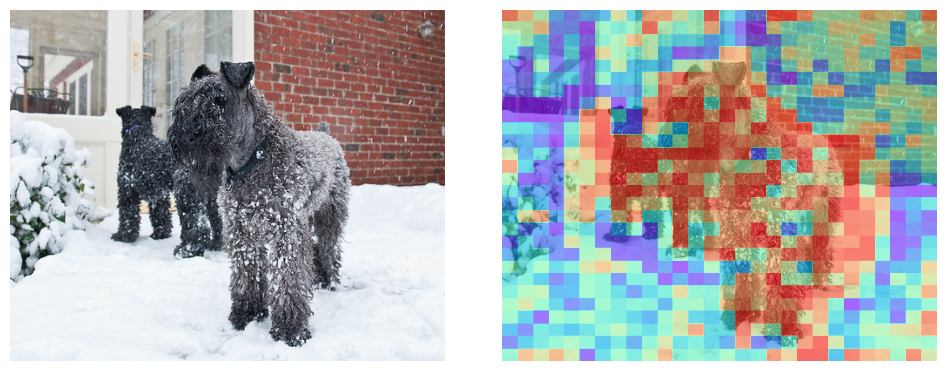

: 

In [295]:
attn = ma_list[-1][0,5,:,:]

attn[attn==np.max(attn)] = np.max(attn)
m = np.mean(attn)
attn[attn<=m*1.3] = attn[attn<=m*1.3]
visualize_grid_to_grid(np.exp(attn*0.1), grid_index=0 , image=img, grid_size=28)
# for i in range(6):
#     for j in range(1):
#         # print(ma_list[-1][0,i,:,:]*2)
#         visualize_grid_to_grid(np.exp(ma_list[-1][0,i,:,:]*0.00001 ), grid_index=j , image=img, grid_size=28)